In [1]:
import numpy as np
import pydot
import os
from IPython.display import SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    RotationMatrix,
    StateInterpolatorWithDiscreteDerivative,
    ConstantVectorSource,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.scenarios import AddMultibodyTriad, MakeManipulationStation
from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.multibody import inverse_kinematics
import copy

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
hydro_bubble_gripper = "../gripper_sdfs/schunk_wsg_50_hydro_bubble.sdf"
allegro_hand = "../gripper_sdfs/allegro_hand_description_right.sdf"
model = os.path.join(os.getcwd(), allegro_hand)

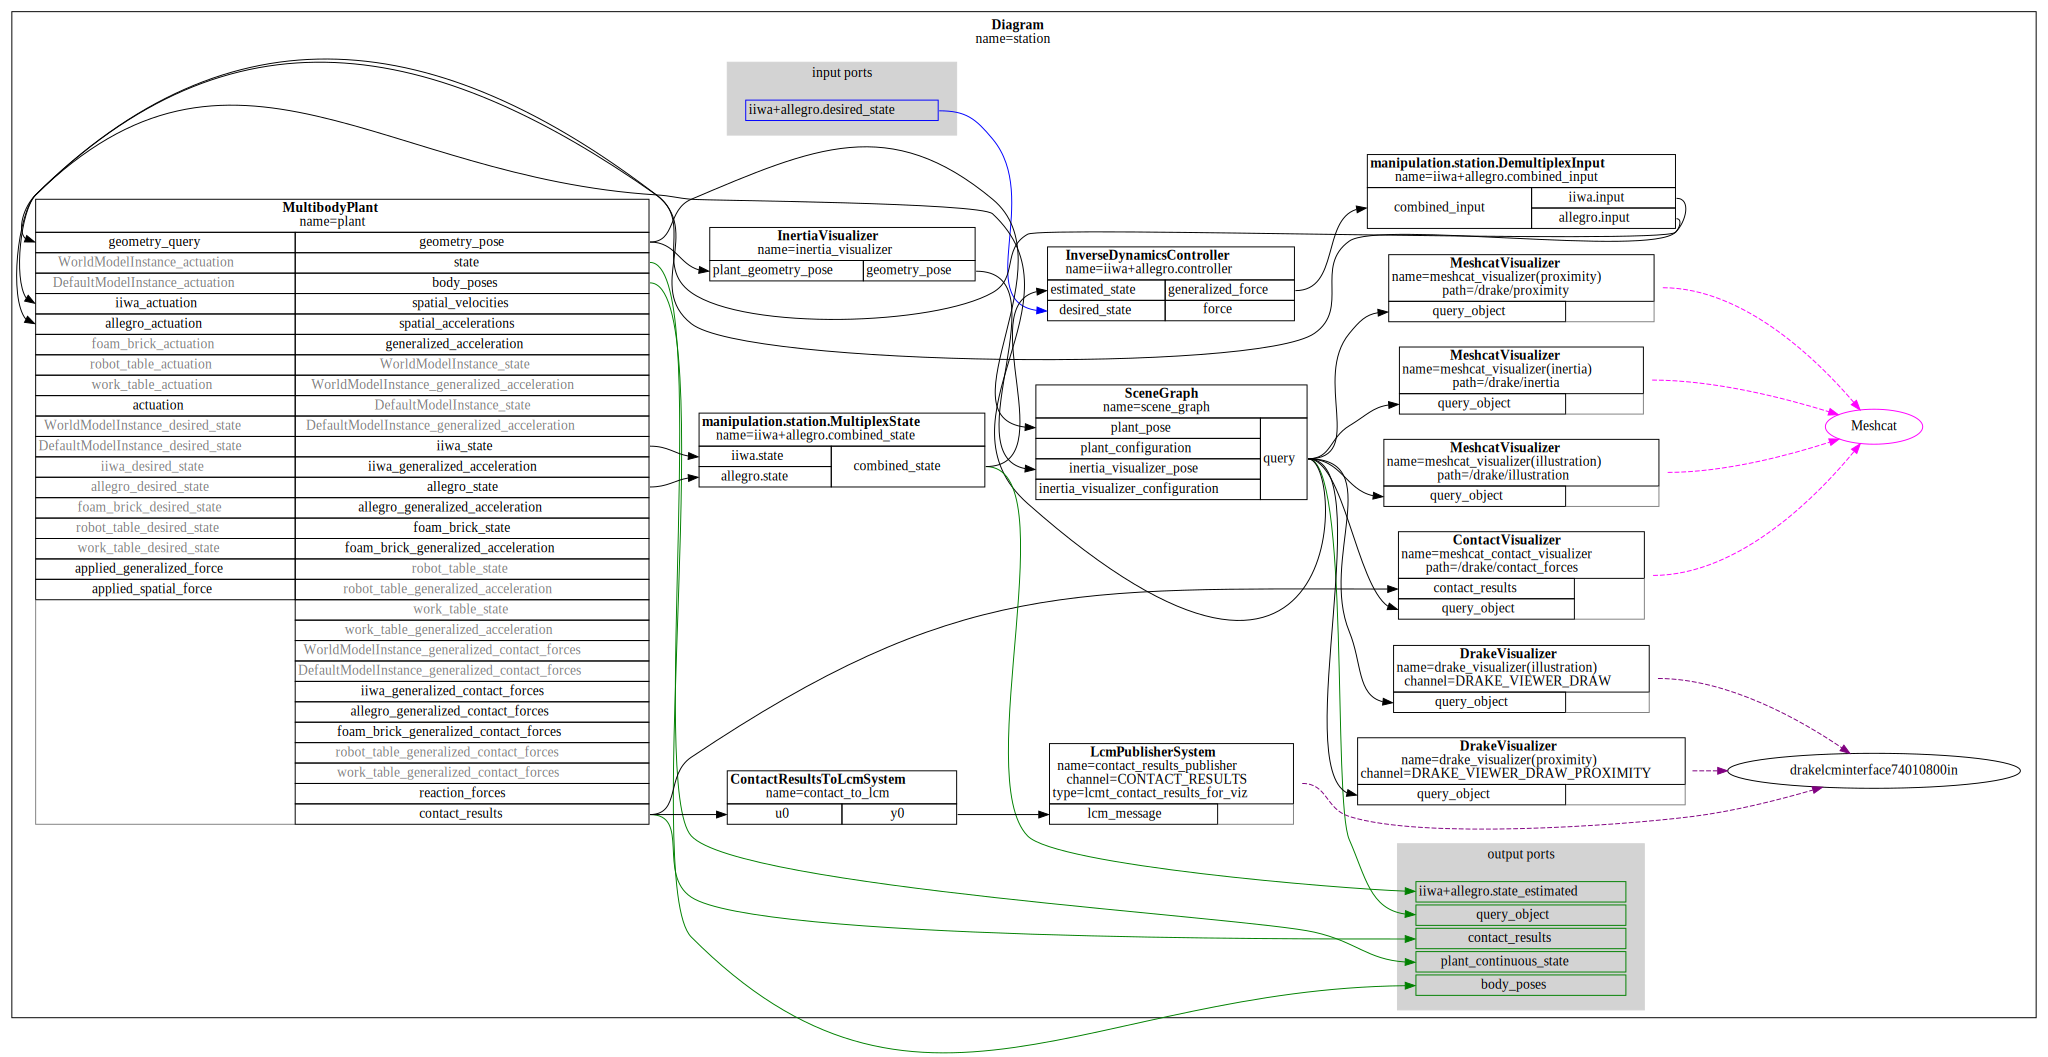

In [4]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.5]
        iiwa_joint_5: [0]
        iiwa_joint_6: [0]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: allegro
    file: file://""" + model + """
- add_weld:
    parent: iiwa::iiwa_link_7
    child: allegro::hand_root
    X_PC:
        translation: [0, 0, 0.05]
        rotation: !Rpy { deg: [0, 0, 0]}
# And now the environment:
- add_model:
    name: foam_brick
    file: package://drake/examples/manipulation_station/models/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0.6, 0, 0]
- add_model:
    name: robot_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: robot_table::link
    X_PC:
        translation: [0, 0, -0.7645]
- add_model:
    name: work_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: work_table::link
    X_PC:
        translation: [0.75, 0, -0.7645]
model_drivers:
    iiwa+allegro: !InverseDynamicsDriver {}
"""

scenario = load_scenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat)

display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

simulator = Simulator(station)
context = simulator.get_mutable_context()

x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)

# Confirm that simulation works:
simulator.AdvanceTo(0.1)

In [5]:
plant = station.GetSubsystemByName("plant")

In [6]:
# Get initial pose of the gripper by using default context of manip station.
frame = "hand_root"
gripper = plant.GetBodyByName(frame)
plant_context = plant.GetMyContextFromRoot(context)
initial_pose = plant.EvalBodyPoseInWorld(plant_context, gripper)

In [7]:
final_rotation = initial_pose.rotation()
initial_position = initial_pose.translation()
final_position = copy.deepcopy(initial_position)
final_position[2] = -0.2
# final_position = [0.6, 0, -0.2]
# linearly interpolate between initial and final position
num_knot_points = 10
t_list = np.arange(num_knot_points)
positions = np.zeros((num_knot_points, 3))
for i in range(3):
    positions[:, i] = np.linspace(
        initial_position[i], final_position[i], num_knot_points
    )
p_list = []
for p in positions:
    p_list.append(RigidTransform(final_rotation, p))

In [8]:

# p_WR = np.array([0.7477, -0.1445, 0.4148])  # frame R: center of left door.

# p_Rhandle = np.array(
#     [-0.033, 0.1245, 0]
# )  # handle: frame attached to right handle.
# p_Whandle = p_WR + p_Rhandle

# p_Rhinge = np.array(
#     [0.008, -0.1395, 0]
# )  # hinge: frame attached to right hinge.
# p_Whinge = p_WR + p_Rhinge

# p_Rhinge_handle = p_Rhandle - p_Rhinge
# r_Rhinge_handle = np.linalg.norm(
#     p_Rhandle - p_Rhinge
# )  # distance between handle and hinge.

# theta_Rhinge_handle = np.arctan2(p_Rhinge_handle[1], p_Rhinge_handle[0])
# angle_end = (
#     np.pi
# )  # end of angle. Decrease to 120~160 deg for the easy version.


# # Interpolate pose for opening doors.
# def InterpolatePoseOpen(t):
#     # Start by interpolating the yaw angle of the hinge.
#     angle_start = theta_Rhinge_handle
#     theta = angle_start + (angle_end - angle_start) * t
#     # Convert to position and rotation.
#     p_Whandle = (
#         r_Rhinge_handle * np.array([np.cos(theta), np.sin(theta), 0])
#         + p_Whinge
#     )
#     # Add some offset here to account for gripper yaw angle.
#     R_Whandle = RollPitchYaw(0, 0, theta).ToRotationMatrix()
#     X_Whandle = RigidTransform(R_Whandle, p_Whandle)

#     # Add a little offset to account for gripper.
#     p_handleG = np.array([0.0, 0.1, 0.0])
#     R_handleG = RollPitchYaw(0, np.pi, np.pi).ToRotationMatrix()
#     X_handleG = RigidTransform(R_handleG, p_handleG)
#     X_WG = X_Whandle.multiply(X_handleG)
#     return X_WG


# ## Interpolate Pose for entry.
# def make_gripper_orientation_trajectory():
#     traj = PiecewiseQuaternionSlerp()
#     traj.Append(0.0, initial_pose.rotation())
#     traj.Append(5.0, InterpolatePoseOpen(0.0).rotation())
#     return traj


# def make_gripper_position_trajectory():
#     traj = PiecewisePolynomial.FirstOrderHold(
#         [0.0, 5.0],
#         np.vstack(
#             [
#                 [initial_pose.translation()],
#                 [InterpolatePoseOpen(0.0).translation()],
#             ]
#         ).T,
#     )
#     return traj


# entry_traj_rotation = make_gripper_orientation_trajectory()
# entry_traj_translation = make_gripper_position_trajectory()


# def InterpolatePoseEntry(t):
#     return RigidTransform(
#         RotationMatrix(entry_traj_rotation.orientation(t)),
#         entry_traj_translation.value(t),
#     )


# # Wrapper function for end-effector pose. Total time: 11 seconds.
# def InterpolatePose(t):
#     if t < 5.0:
#         # Duration of entry motion is set to 5 seconds.
#         return InterpolatePoseEntry(t)
#     elif (t >= 5.0) and (t < 6.0):
#         # Wait for a second to grip the handle.
#         return InterpolatePoseEntry(5.0)
#     else:
#         # Duration of the open motion is set to 5 seconds.
#         return InterpolatePoseOpen((t - 6.0) / 5.0)


# # Visualize our end-effector nominal trajectory.
# t_lst = np.linspace(0, 11, 30)
# pose_lst = []
# for t in t_lst:
#     AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePose(t), opacity=0.2)
#     pose_lst.append(InterpolatePose(t))

In [9]:
def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant = station.GetSubsystemByName("plant")
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName(frame)
    iiwa_initial = np.array([0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0])
    gripper_initial = np.ones((23))
    q_nominal = np.hstack((iiwa_initial, gripper_initial))
    # q_nominal = iiwa_initial
    print(q_nominal.shape)

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        # q_variables = ik.q()  # Get variables for MathematicalProgram
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################
        pose = pose_lst[i]
        AddPositionConstraint(
                    ik,
                    pose.translation(),
                    pose.translation(),

        )
        # AddOrientationConstraint(
        #     ik,
        #     pose.rotation(),
        #     0.02,
        # )
        prog.AddQuadraticErrorCost(np.identity(len(q_variables)), q_nominal, q_variables)
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i-1])
        ###############################################

        result = Solve(prog)

        assert result.is_success()
        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [10]:
# q_knots = np.array(create_q_knots(pose_lst))
# q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
q_knots = np.array(create_q_knots(p_list))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_list, q_knots.T)

(30,)


In [11]:
def move_hand(station, context, end_point):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[:end_point.shape[0]] = end_point
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [12]:
contact = station.GetOutputPort("contact_results").Eval(context)
init_num_contacts = contact.num_point_pair_contacts()
contact_pre_move = []
for i in range(init_num_contacts):
    contact_pre_move.append(contact.point_pair_contact_info(i).contact_point())
print(contact_pre_move)

[array([ 6.37500000e-01,  2.50000000e-02, -4.04398746e-06]), array([ 6.37500000e-01, -2.50000000e-02, -4.04398746e-06]), array([ 5.62500000e-01,  2.50000000e-02, -4.04398746e-06]), array([ 5.62500000e-01, -2.50000000e-02, -4.04398746e-06])]


In [13]:
all_q = q_knots[:, :7]
for each_q in q_knots:
    move_hand(station, context, each_q)
    simulator.AdvanceTo(simulator.get_context().get_time() + 0.05)
    contact = station.GetOutputPort("contact_results").Eval(context)
    num_contacts = contact.num_point_pair_contacts()
    if num_contacts != init_num_contacts:
        print("contact changed")
        break

contact changed


In [14]:
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
contact_post_move = []
for i in range(num_contacts):
    # if contact.point_pair_contact_info(i).contact_point() not in contact_pre_move:
    contact_post_move.append(contact.point_pair_contact_info(i).contact_point())
contact_post_move

[array([ 5.25850778e-01,  1.45959187e-01, -4.35200873e-04]),
 array([ 6.37500000e-01,  2.50000000e-02, -1.01064122e-05]),
 array([ 6.37500000e-01, -2.50000000e-02, -1.01064122e-05]),
 array([ 5.62500000e-01,  2.50000000e-02, -1.01064122e-05]),
 array([ 5.62500000e-01, -2.50000000e-02, -1.01064122e-05])]

In [15]:
station.GetInputPort("iiwa+allegro.position_measured").FixValue(context, q_knots[0])

RuntimeError: System station does not have an input port named iiwa+allegro.position_measured (valid port names: iiwa+allegro.desired_state)

In [ ]:
contact = station.GetOutputPort("contact_results").Eval(context)
contact.point_pair_contact_info(2).contact_force

AttributeError: 'pydrake.multibody.plant.PointPairContactInfo' object has no attribute 'contact_forces'

In [ ]:
time = 0.2

In [ ]:
station.GetInputPort("iiwa+allegro.desired_state").Eval(context)[:7]

array([ 0. ,  0.1,  0. , -1.5,  0. ,  0. ,  0. ])

In [ ]:
def open_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[8] = 4
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
def close_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[8] = 0
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
allegro_map = {
    "index_revolute": 7,
    "index_0": 8,
    "index_1": 9,
    "index_2": 10,
    "thumb_": 11,
    "thumb_1": 12, 
    "thumb_revolute_z": 11,
    "thumb_revolute_y": 12, # avoid
    "thumb_joint_1": 13,
    "thumb_joint_2": 14,
    "middle_revolute": 15,
    "middle_0": 16,
    "middle_1": 17,
    "middle_2": 18,
    "pinky_revolute": 19,
    "pinky_0": 20,
    "pinky_1": 21,
    "pinky_2": 22
}

In [ ]:
def reset_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[7:] = 0
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
def move_finger(station, context, index, amount):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[index] = amount
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

index = 22
amount = 2

reset_hand(station, context)
simulator.AdvanceTo(time) 
time += 1

move_finger(station, context, index, amount)
simulator.AdvanceTo(time)
time += 1

In [ ]:
open_hand(station, context)
simulator.AdvanceTo(time)
time += 1

In [ ]:
close_hand(station, context)
simulator.AdvanceTo(time)
time += 1

In [ ]:
plant.get_contact_model()

<ContactModel.kHydroelasticWithFallback: 2>

In [ ]:
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
print(num_contacts)
a = contact.point_pair_contact_info(1)
a.contact_point()

8


array([ 7.20192680e-01,  1.15709952e-01, -5.80416268e-05])

[0.76671662 0.15635648 0.029096  ]
[ 7.20192680e-01  1.15709952e-01 -5.80416268e-05]
[0.80215838 0.10720572 0.02441489]
[ 7.95898018e-01  9.72281132e-02 -2.13457851e-04]
[ 6.37500001e-01  2.50000016e-02 -7.61718707e-06]
[ 6.37500002e-01 -2.49999973e-02 -1.28237572e-05]
[ 5.62500002e-01  2.50000026e-02 -1.28237666e-05]
[ 5.62500003e-01 -2.49999963e-02 -1.80303367e-05]


In [ ]:
end_effector_frame = station.